In [1]:
import os, sys, math
from typing import Optional, Callable

import matplotlib
from lib.structs import WorkerParam, InputParam, TestParamGroup
from lib.db import RecordManager
from lib.sut import SystemUnderTest
from lib.run_test_param_group import run_test_params

db_dir = "../../db-identical-req.sqlite"
model_dir = "/mnt/petrelfs/wubingyang/intlsy/weights/LWM-Text-1M"
mode = ["_token_decode_attention_overlapped"]

# SOSP's requirement
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

record_manager = RecordManager(filename=db_dir)

# Select one record to verify that the database is loaded correctly
record_manager.cur.execute("SELECT * FROM records LIMIT 1")
print(dict(record_manager.cur.fetchone()))

{'id': 15, 'sp_world_size': 1, 'tp_world_size': 1, 'batch_size': 1, 'input_len': 1000, 'output_len': 16, 'num_sp_master': 1, 'need_context_migration': 0, 'num_decoding_stage_migration': 0, 'avg_prefill_time_usage': 68.88760375976562, 'avg_decoding_time_usage': 13.01193618774414, 'prefill_time_stddev': 0.2077266821374443, 'decoding_time_stddev': 0.05105810686801651, 'tag': "/mnt/petrelfs/wubingyang/intlsy/weights/LWM-Text-1M,['_token_decode_attention_overlapped']"}


/home/intlsy/mambaforge/envs/temp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def _fetch_result_or_run(
	worker_param: WorkerParam,
	input_param: InputParam,
	rerun_if_missing: bool = True
) -> Optional[tuple[float, float]]:
	"""
	Fetch the experiment result (prefill_time, decoding_time) from the db if it exists,
	or run the experiment and save the result to the db.
	"""
	cached_result = record_manager.query_record(worker_param, input_param)
	if cached_result is not None:
		return cached_result["avg_prefill_time_usage"], cached_result["avg_decoding_time_usage"]
	
	if not rerun_if_missing:
		return None
	import torch
	if torch.cuda.device_count() == 0:
		print(f"Some data is lacking. Please re-run this notebook on compute nodes (i.e. via `srun`) and it will automatically perform essential experiments")
		print(f"Missing: \n{worker_param=}\n{input_param=}")
		sys.exit(1)
	run_test_params([TestParamGroup(worker_param, [input_param])], record_manager)
	return _fetch_result_or_run(worker_param, input_param, rerun_if_missing)

def fetch_result_or_run(
	sp_world_size: int,
	tp_world_size: int,
	batch_size: int,
	input_len: int,
	output_len: int,
	num_sp_master: int = 1,
	need_context_migration: bool = False,
	num_decoding_stage_migration: int = 0,
	rerun_if_missing: bool = True,
) -> Optional[tuple[float, float]]:
	"""
	A wrapper around `_fetch_result_or_run` that provides a simplified interface.
	"""
	worker_param = WorkerParam(
		model_dir,
		sp_world_size,
		tp_world_size,
		0,
		0,
		0,
		mode
	)
	input_param = InputParam(
		batch_size,
		input_len,
		output_len,
		num_sp_master,
		need_context_migration,
		num_decoding_stage_migration
	)
	return _fetch_result_or_run(worker_param, input_param, rerun_if_missing)

print(fetch_result_or_run(1, 1, 1, 10, 16))
print(fetch_result_or_run(114, 514, 19, 19, 810, rerun_if_missing=False))

(18.580020904541016, 11.377375602722168)
None


In [3]:
from matplotlib import pyplot as plt
import matplotlib.axes as mpl_axes
import numpy as np
from matplotlib import ticker as mticker

def set_xinjin_style(ax: mpl_axes.Axes):
	ax.tick_params('x', direction="in")
	ax.tick_params('y', direction="in")
	ax.spines['top'].set_color(None)
	ax.spines['right'].set_color(None)

def save_fig_to_pdf(filename: str):
	if filename.endswith(".pdf"):
		filename = filename[:-4]
	plt.savefig(f"output-pdfs/{filename}.pdf", bbox_inches='tight', transparent=True)
	os.system(f"ps2pdf -dEPSCrop output-pdfs/{filename}.pdf output-pdfs/{filename}_.pdf")



# Exp 1 & Exp 2

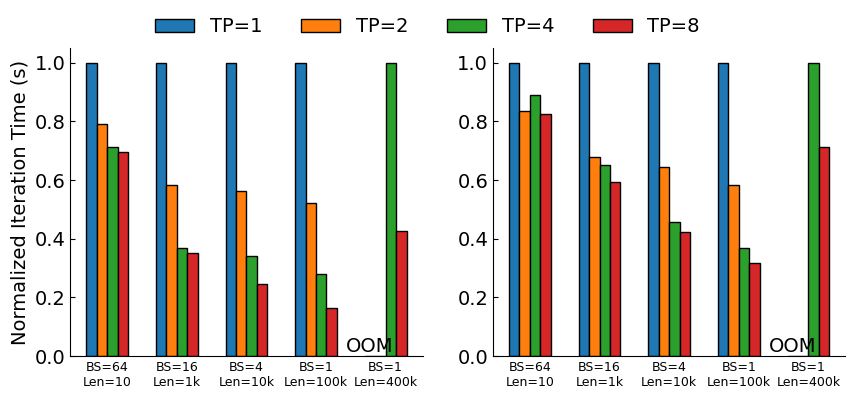

In [4]:
import math

def draw_exp1_plot():
	plt.rcParams.update({"font.size": 14})
	tp_world_sizes = [1, 2, 4, 8]
	batch_size_and_input_lens = [
		(64, 10, "10"),
		(16, 1000, "1k"),
		(4, 10000, "10k"),
		(1, 100000, "100k"),
		(1, 400000, "400k"),
	]
	output_len = 16
	bar_width = 0.15

	data = np.array([
		[
			fetch_result_or_run(
				1,
				tp_world_size,
				batch_size,
				input_len,
				output_len
			) if batch_size * input_len <= 100000*tp_world_size else (0, 0)
			for (batch_size, input_len, _) in batch_size_and_input_lens
		]
		for tp_world_size in tp_world_sizes
	])	# [num_tps, num_batch_size_input_lens, 2]
	# Normalization
	data /= np.max(data, axis=0, keepdims=True)

	def plot_figure(ax: mpl_axes.Axes, title: str, retriver: Callable):
		xs_base = np.arange(len(batch_size_and_input_lens))
		for i, tp_world_size in enumerate(tp_world_sizes):
			xs = xs_base + bar_width*i
			label = f"TP={tp_world_size}"
			cur_data = [retriver(x) for x in data[i]]
			ax.bar(xs, cur_data, bar_width, label=label, edgecolor="black")
			for (x, d) in zip(xs, cur_data):
				if d == 0 and i == 0:
					ax.text(x, 0.0, "OOM", ha='center', va='bottom', color='black')
		xticks = [f"BS={batch_size}\nLen={input_len_display}" for (batch_size, input_len, input_len_display) in batch_size_and_input_lens]
		ax.set_xticks(xs_base + bar_width*(len(tp_world_sizes)-1)/2, xticks, size=9)
		set_xinjin_style(ax)
			
	fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
	ax0.set_ylabel("Normalized Iteration Time (s)")
	plot_figure(ax0, "Prefill Phase", lambda x: x[0])
	fig.legend(frameon=False, loc="upper center", ncol=4, prop={'size': 14})
	plot_figure(ax1, "Decoding Phase", lambda x: x[1])

	save_fig_to_pdf("motivation_scaling_curves_short")
	plt.show()

draw_exp1_plot()

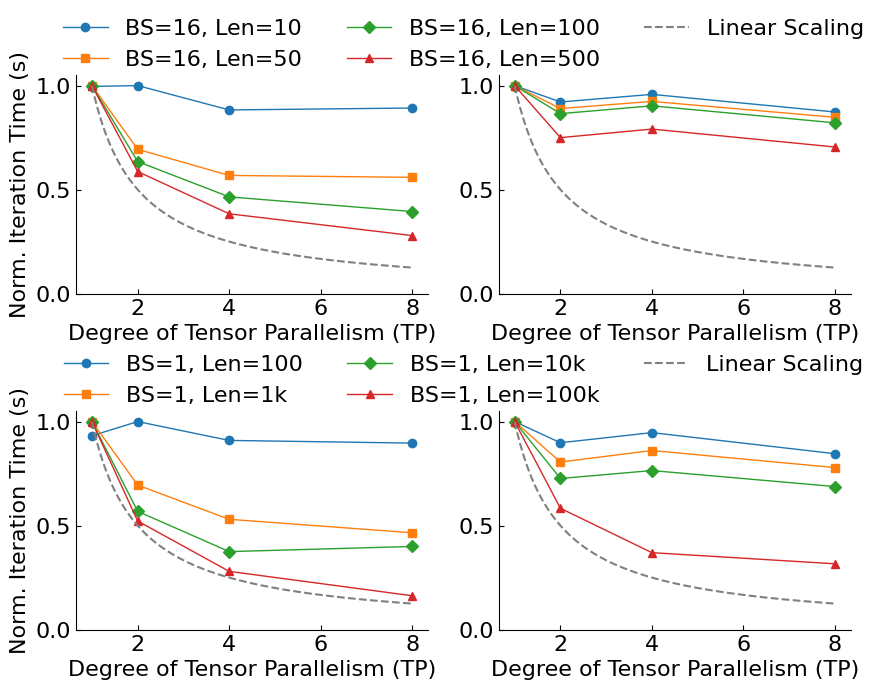

In [18]:
def draw_exp1_plot_2():
    plt.rcParams.update({"font.size": 16})
    tp_world_sizes = [1, 2, 4, 8]
    batch_size_and_input_lens_short_requests = [
        (16, 10, "10"),
        (16, 50, "50"),
        (16, 100, "100"),
        (16, 500, "500"),
    ]
    batch_size_and_input_lens_long_requests = [
        (1, 100, "100"),
        (1, 1000, "1k"),
        (1, 10000, "10k"),
        (1, 100000, "100k"),
    ]
    markers = ['o', 's', 'D', '^']
    output_len = 16

    def plot_figure(ax: mpl_axes.Axes, title: str, batch_size_and_input_lens: list, is_decoding_stage: bool, normalize: bool):
        retriever = lambda x: x[1] if is_decoding_stage else x[0]
        data = np.array([
            [
                retriever(fetch_result_or_run(
                    1,
                    tp_world_size,
                    batch_size,
                    input_len,
                    output_len
                )) if batch_size*input_len <= 100000*tp_world_size else 0
                for (batch_size, input_len, _) in batch_size_and_input_lens
            ]
            for tp_world_size in tp_world_sizes
        ])	# [num_tps, num_batch_size_input_lens, 2]
        for i in range(len(batch_size_and_input_lens)):
            cur_data = data[:, i]
            if normalize:
                cur_data /= np.max(cur_data)
            ax.plot(
                tp_world_sizes,
                cur_data, 
                marker=markers[i],
                label=f"BS={batch_size_and_input_lens[i][0]}, Len={batch_size_and_input_lens[i][2]}", linewidth=1
            )
        
        linear_scaling_xs = np.arange(1, 8, 0.02)
        ax.plot(
            linear_scaling_xs,
            [1/x for x in linear_scaling_xs],
            "--",
            label="Linear Scaling",
            color="grey"
        )

        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position((box.x0, box.y0, box.width, box.height*0.78))
        ax.set_xlabel("Degree of Tensor Parallelism (TP)")
        set_xinjin_style(ax)
        if normalize:
            ax.set_ylim(0, 1.05)
            
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs[0][0].set_ylabel("Norm. Iteration Time (s)")
    axs[1][0].set_ylabel("Norm. Iteration Time (s)")

    plot_figure(axs[0][0], "Prefill Phase, Short Request", batch_size_and_input_lens_short_requests, is_decoding_stage=False, normalize=True)

    plot_figure(axs[0][1], "Decoding Phase, Short Request", batch_size_and_input_lens_short_requests, is_decoding_stage=True, normalize=True)

    plot_figure(axs[1][0], "Prefill Phase, Long Request", batch_size_and_input_lens_long_requests, is_decoding_stage=False, normalize=True)

    plot_figure(axs[1][1], "Decoding Phase, Long Request", batch_size_and_input_lens_long_requests, is_decoding_stage=True, normalize=True)

    axs[0][0].legend(frameon=False, loc="upper center", ncols=3, bbox_to_anchor=(1.1, 1.35))
    axs[1][0].legend(frameon=False, loc="upper center", ncols=3, bbox_to_anchor=(1.1, 1.35))

    save_fig_to_pdf("motivation_scaling_curves")
    plt.show()

draw_exp1_plot_2()

# Figure 3

[[[7.75744792e+03 3.88672333e+01]
  [1.01569834e+04 3.77617607e+01]
  [1.07919287e+04 3.63806725e+01]
  [1.95064590e+04 4.29301453e+01]
  [1.35463018e+04 2.63580799e+01]
  [5.11354727e+04 3.75766411e+01]]

 [[5.77561035e+03 4.25490227e+01]
  [7.69433708e+03 4.03438072e+01]
  [8.30622852e+03 3.81499519e+01]
  [1.65949655e+04 4.49204788e+01]
  [1.21469896e+04 2.80251846e+01]
  [5.16998516e+04 4.16053772e+01]]

 [[5.26709619e+03 4.22528954e+01]
  [7.07178418e+03 4.13734093e+01]
  [7.70112939e+03 4.01384010e+01]
  [1.57444495e+04 4.58901443e+01]
  [1.17983678e+04 2.89095688e+01]
  [5.36058984e+04 3.77857933e+01]]]


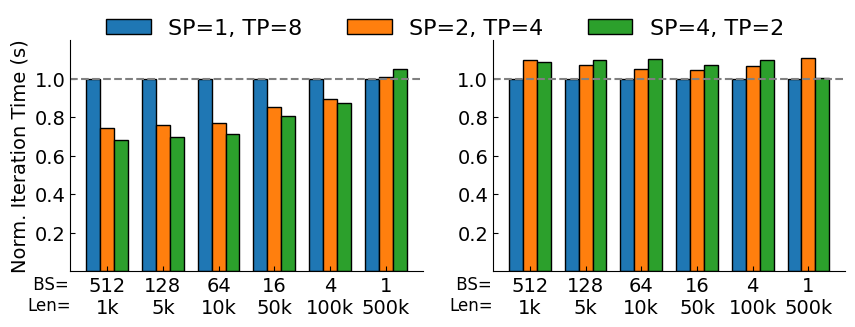

In [19]:
def draw_exp3_plot():
	plt.rcParams.update({"font.size": 14})
	sp_and_tp_world_sizes = [
		(1, 8),
		(2, 4),
		(4, 2),
	]
	batch_size_and_input_lens = [
		(512, 1000, [1, 2, 4]),
		(128, 5000, [1, 1, 2]),
		(64, 10000, [1, 1, 2]),
		(16, 50000, [1, 1, 1]),
		(4, 100000, [1, 1, 1]),
		(1, 500000, [1, 1, 1])
	]
	output_len = 16
	bar_width = 0.25

	data = np.array([
		[ 
			fetch_result_or_run(
				sp_world_size,
				tp_world_size,
				batch_size,
				input_len,
				output_len,
				num_sp_master = num_sp_masters[sp_tp_index]
			)
			for (batch_size, input_len, num_sp_masters) in batch_size_and_input_lens
		]
		for sp_tp_index, (sp_world_size, tp_world_size) in enumerate(sp_and_tp_world_sizes)
	])	# [num_tps, num_batch_size_input_lens, 2]
	# Normalization (respective to SP=1)
	print(data)
	assert sp_and_tp_world_sizes[0][0] == 1
	data /= data[0, :, :]

	def plot_figure(ax: mpl_axes.Axes, title: str, retriver: Callable):
		xs_base = np.arange(len(batch_size_and_input_lens))
		for i, (sp_world_size, tp_world_size) in enumerate(sp_and_tp_world_sizes):
			xs = xs_base + bar_width*i
			label = f"SP={sp_world_size}, TP={tp_world_size}"
			cur_data = [retriver(x) for x in data[i]]
			ax.bar(xs, cur_data, bar_width, label=label, edgecolor="black")
			
		xticks = []
		for (i, (batch_size, input_len, _)) in enumerate(batch_size_and_input_lens):
			input_len_text = (str(input_len // 1000) + "k") if input_len >= 1000 else input_len
			if i == 0:
				xticks.append(f"{batch_size}\n{input_len_text}")
			else:
				xticks.append(f"{batch_size}\n{input_len_text}")
		ax.set_xticks(xs_base + bar_width*(len(sp_and_tp_world_sizes)-1)/2, xticks)
		ax.axhline(y = 1.0, color="grey", linestyle="--")
		ax.text(-0.8, -0.022, " BS=\nLen=", ha='center', va='top', color='black', fontsize=12)
		ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
		set_xinjin_style(ax)
			
	fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3))
	ax0.set_ylabel("Norm. Iteration Time (s)")
	
	plot_figure(ax0, "Prefill Phase", lambda x: x[0])
	ax0.set_ylim(0, 1.2)
	ax1.set_ylim(0, 1.2)
	fig.legend(frameon=False, loc="upper center", ncol=4, prop={'size': 16}, bbox_to_anchor=(0.5, 1.02))
	plot_figure(ax1, "Decoding Phase", lambda x: x[1])

	save_fig_to_pdf("motivation_sp_performance")
	plt.show()

draw_exp3_plot()

# Figure 14

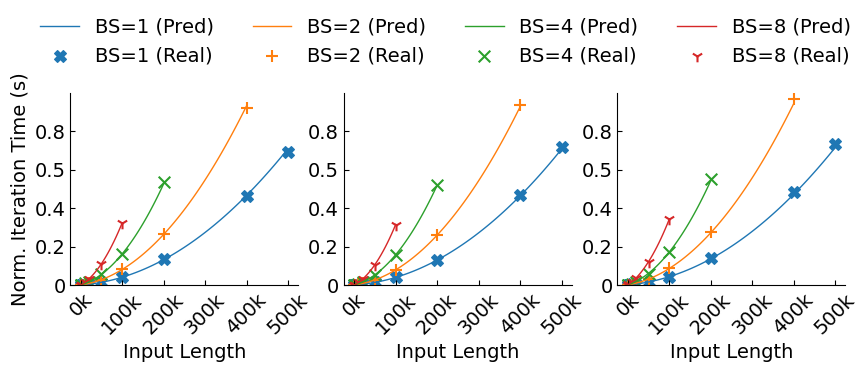

In [32]:
import csv
class Profiler:
    def __init__(self, profiler_file_path: str = "../../profiler_parameters.csv"):
        self.predictor_parameters: dict[tuple[int, int], tuple[float, float, float]] = {}
        with open(profiler_file_path, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                sp_world_size = int(row['sp_world_size'])
                tp_world_size = int(row['tp_world_size'])
                A = float(row['A'])
                B = float(row['B'])
                C = float(row['C'])
                self.predictor_parameters[(sp_world_size, tp_world_size)] = (A, B, C)
    
    def _predict(self, sp_world_size:int, tp_world_size:int, req_input_sum: int, req_input_square_sum: int) -> float:
        A, B, C = self.predictor_parameters[(sp_world_size, tp_world_size)]
        return A + B * req_input_sum + C * req_input_square_sum

    def predict(self, sp_world_size: int, tp_world_size: int, batch_size: int, input_len: int) -> float:
        return self._predict(sp_world_size, tp_world_size, batch_size * input_len, batch_size * input_len * input_len)      
    
def draw_exp4_plot():
    plt.rcParams.update({"font.size": 14})
    sp_and_tp_sizes = [
        (2, 4),
        (4, 2),
        (8, 1)
    ]
    batch_sizes = [1, 2 ,4, 8]
    colors = ["C0", "C1", "C2", "C3", "cyan", "purple", "brown", "yellow"]
    input_lens_pred = [
        10, 100, 1000
    ] + list(range(5000, 500000+1, 5000))
    input_lens_real = [
        10, 100, 1000, 10000, 20000, 50000, 100000, 200000, 400000, 500000
    ]
    output_len = 16
    markers = ['X', '+', 'x', '1']

    profiler = Profiler()
    def plot(ax: mpl_axes.Axes, sp_world_size: int, tp_world_size: int):
        for i, batch_size in enumerate(batch_sizes):
            real_data = []
            for input_len in input_lens_real:
                result = fetch_result_or_run(
                    sp_world_size,
                    tp_world_size,
                    batch_size,
                    input_len,
                    output_len,
                    rerun_if_missing = False
                )
                if result is None:
                    break
                else:
                    real_data.append(result[0]/1000)
            cur_input_lens_real = input_lens_real[:len(real_data)]

            cur_input_lens_pred = [input_len for input_len in input_lens_pred if input_len <= cur_input_lens_real[-1]]
            pred_data = np.array([
                profiler.predict(sp_world_size, tp_world_size, batch_size, input_len)/1000
                for input_len in cur_input_lens_pred
            ])

            ax.plot(cur_input_lens_pred, pred_data, color=colors[i], label=f"BS={batch_size} (Pred)", linewidth=1)
            ax.scatter(cur_input_lens_real, real_data, color=colors[i], marker=markers[i], s=70, label=f"BS={batch_size} (Real)")
            set_xinjin_style(ax)
            ax.set_xlabel("Input Length")

            ax.set_xticks([0, 100000, 200000, 300000, 400000, 500000])
            ax.set_xticklabels([f"{x/1000:.0f}k" for x in ax.get_xticks()], rotation=45)
            ax.set_ylim(0, 75)
            ax.set_yticks([0, 15, 30, 45, 60])
            ax.set_yticklabels([0, 0.2, 0.4, 0.5, 0.8])
            
    fig, axs = plt.subplots(1, len(sp_and_tp_sizes), figsize=(10, 2.5))
    for i in range(len(sp_and_tp_sizes)):
        plot(axs[i], sp_and_tp_sizes[i][0], sp_and_tp_sizes[i][1])
        if i == 0:
            fig.legend(frameon=False, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.25))
    axs[0].set_ylabel("Norm. Iteration Time (s)")

    save_fig_to_pdf("evaluation_analytical_model_accuracy")
    plt.show()

draw_exp4_plot()